# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign, get_fields
from mpi4py import MPI
from params import nz
from petsc4py import PETSc
from solvers import initialize,solve_pde, time_stepping
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_steady
from post_process import interp
from scipy.interpolate import interp1d
# import sympy as sp

Define domain:

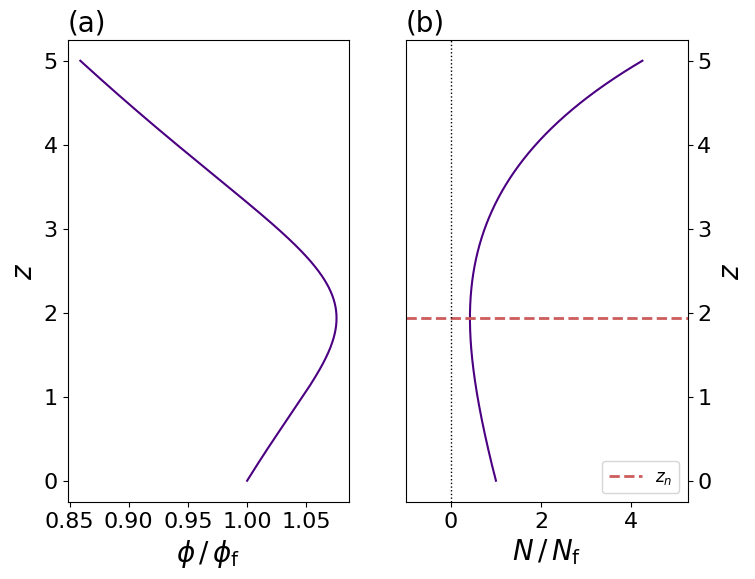

In [3]:
# generate mesh
N_f = 2  # effective stress at base of fringe 
z_l = 5
z_b = 1e-3
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])

# define initial condition N that satisfies the
# elliptic problem: D(phi,S) N']' = F(phi,S)   
# which is valid for rigid solutions (dN/dt + v_i dN/dz = 0)
initial = initialize(domain,N_f,eps_min=1e-10)

# interpolate solution, save in numpy arrays, and plot
z,N = interp(initial,domain)
plot_steady(N,z)

In [4]:
# set freezing speed and timesteps 
v_i = 0.025
timesteps = np.linspace(0,1e3,1000)

# solve the time-dependent problem
N,z,new_lens,heave,converged = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

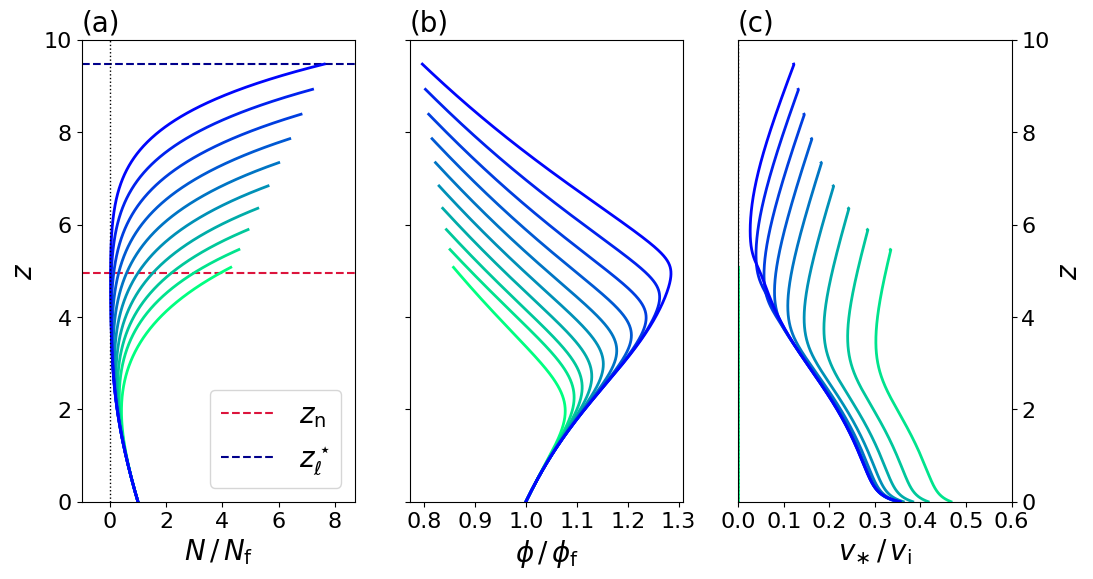

In [5]:
# plot solution up to first ice lens initiation
l0 = np.where(new_lens==1)[0]
if np.size(l0)== 0:
    l0 = None
else:
    l00 = l0[0]
    l01 = l0[1]

# plot(N,heave/v_i,z,timesteps)

plt.figure(figsize=(12,6))
phi = Phi(N,log=np.log)

ind = np.arange(l00,l01,25)

colors = pl.cm.winter_r(np.linspace(0,1,l01-l00))
T,S,k = get_fields(z)

j = np.argmax(z[:,-1])

N_f = N[0,0]

z_n = z[ind[-1],np.argmin(N[ind[-1],:])]
z_l = z[ind[-1],-1]


plt.subplot(132)
plt.title(r'(b)',fontsize=20,loc='left')

for i in range(ind.size):
    plt.plot(phi[ind[i],:]/phi[0,0].mean(),z[ind[i],:],color=colors[ind[i]-l00],linewidth=2)
# plt.axhline(0,linestyle='--',color='k',linewidth=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$\phi\,/\,\phi_\mathrm{f}$',fontsize=20)
plt.gca().yaxis.set_ticklabels([])
plt.ylim(0,10)

plt.subplot(131)
plt.title(r'(a)',fontsize=20,loc='left')
plt.ylabel(r'$z$',fontsize=20)

plt.axhline(z_n,linestyle='--',color='crimson',linewidth=1.5,label=r'$z_\mathrm{n}$')
plt.axhline(z_l,linestyle='--',color='darkblue',linewidth=1.5,label=r'$z_\ell^\star$')

for i in range(ind.size):
    plt.plot(N[ind[i],:]/N_f,z[ind[i],:],color=colors[ind[i]-l00],linewidth=2)



# plt.axhline(0,linestyle='--',color='k',linewidth=1)
plt.axvline(0,linestyle=':',color='k',linewidth=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel(r'$N\,/\,N_\mathrm{f}$',fontsize=20)
plt.xlim(-1,N.max()/N_f+1)
plt.legend(fontsize=20,loc='lower right')
plt.ylim(0,10)


plt.subplot(133)
plt.title(r'(c)',fontsize=20,loc='left')
for i in range(ind.size):
    plt.plot(heave[ind[i],:]/v_i,z[ind[i],:],color=colors[ind[i]-l00],linewidth=2)
# plt.axhline(0,linestyle='--',color='k',linewidth=1)
plt.axvline(0,linestyle=':',color='k',linewidth=1)
plt.xticks(fontsize=16)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.yticks(fontsize=16)
plt.ylabel(r'$z$',fontsize=20)
plt.xlabel(r'$v_{\ast}\,/\,v_\mathrm{i}$',fontsize=20)
plt.xlim(0,0.6)
plt.ylim(0,10)
plt.savefig('profiles')
plt.show()
plt.close()

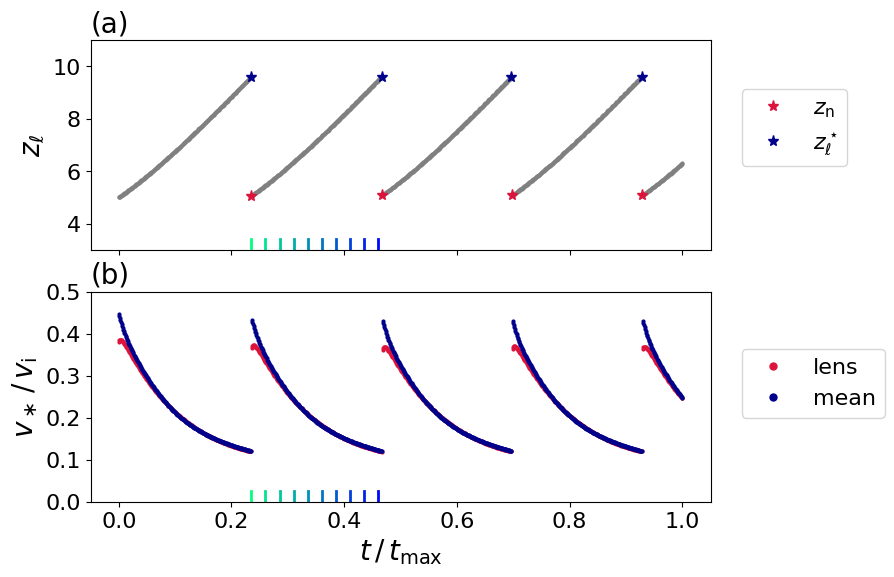

In [6]:
# plot position of active ice lens over time
timesteps_ = timesteps[l00:l01]
ind = np.arange(0,timesteps_.size,25)
colors = pl.cm.winter_r((timesteps_-timesteps[l00])/(timesteps_-timesteps[l00]).max())

z_l = np.max(z,axis=1)
old_lens = np.roll(new_lens,-1)

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.title(r'(a)',fontsize=20,loc='left')
plt.plot(timesteps/timesteps.max(),z_l,'o',markersize=2,color='gray')
plt.plot(timesteps[new_lens==1]/timesteps.max(),z_l[new_lens==1],'*',markersize=8,color='crimson',label=r'$z_\mathrm{n}$')
plt.plot(timesteps[old_lens==1]/timesteps.max(),z_l[old_lens==1],'*',markersize=8,color='darkblue',label=r'$z_\ell^\star$')

if converged == False:
    plt.plot(timesteps[l0+1:None]/timesteps.max(),z_l[l0+1:None],'x',markersize=5)

for i in ind:
    plt.axvline(timesteps_[i]/timesteps.max(),ymax=0.05,color=colors[i],linestyle='-',linewidth=2)
    
lgnd = plt.legend(fontsize=16,loc=(1.05,0.4),ncol=1)
lgnd.legendHandles[0].set_markersize(8)
lgnd.legendHandles[1].set_markersize(8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=20)
plt.ylim(3,11)

plt.gca().xaxis.set_ticklabels([])

plt.subplot(212)
plt.title(r'(b)',fontsize=20,loc='left')
heave_lens = heave[:,-1]/v_i
heave_mean = np.mean(heave,axis=1)/v_i

plt.plot(timesteps[heave_lens!=0]/timesteps.max(),heave_lens[heave_lens!=0],'o',markersize=2,color='crimson',label=r'lens')
plt.plot(timesteps[heave_mean!=0]/timesteps.max(),heave_mean[heave_mean!=0],'o',markersize=2,color='darkblue',label=r'mean')

for i in ind:
    plt.axvline(timesteps_[i]/timesteps.max(),ymax=0.05,color=colors[i],linestyle='-',linewidth=2)
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'${v}_\ast\,/\,v_\mathrm{i}$',fontsize=20)
lgnd = plt.legend(fontsize=16,ncol=1,loc=(1.05,0.4))
lgnd.legendHandles[0].set_markersize(5)
lgnd.legendHandles[1].set_markersize(5)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.ylim(0,0.5)
plt.savefig('example_times',bbox_inches='tight')
plt.show()
plt.close()

In [7]:
phi = Phi(N,log=np.log)
phi_mean = np.mean(phi,axis=1)

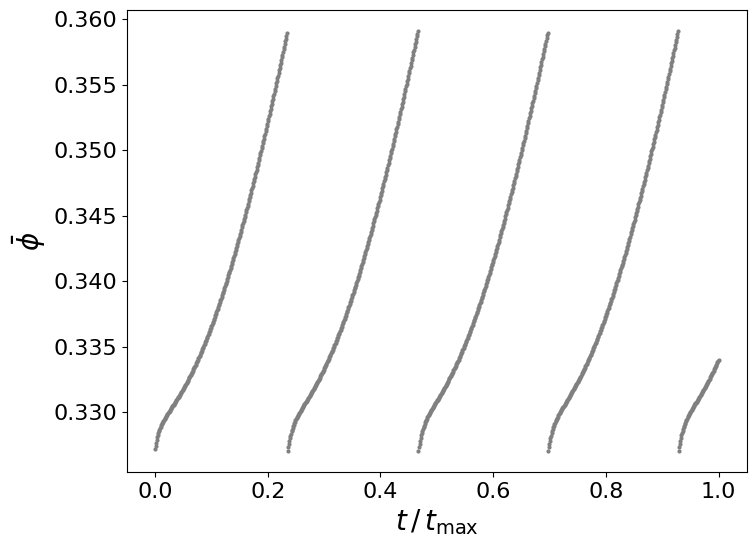

In [8]:
plt.figure(figsize=(8,6))
plt.plot(timesteps/timesteps.max(),phi_mean,'o',markersize=2,color='gray')
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.ylabel(r'$\bar{\phi}$',fontsize=20)  
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
plt.close()